In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [57]:
df = pd.read_csv('NYC-Airbnb-2023.csv', low_memory=False)
print("dataset dimensions:", df.shape)
df.head()

dataset dimensions: (42931, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1,NaN
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0,NaN
2,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0,NaN
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52,NaN
4,5136,"Large Sunny Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1,NaN


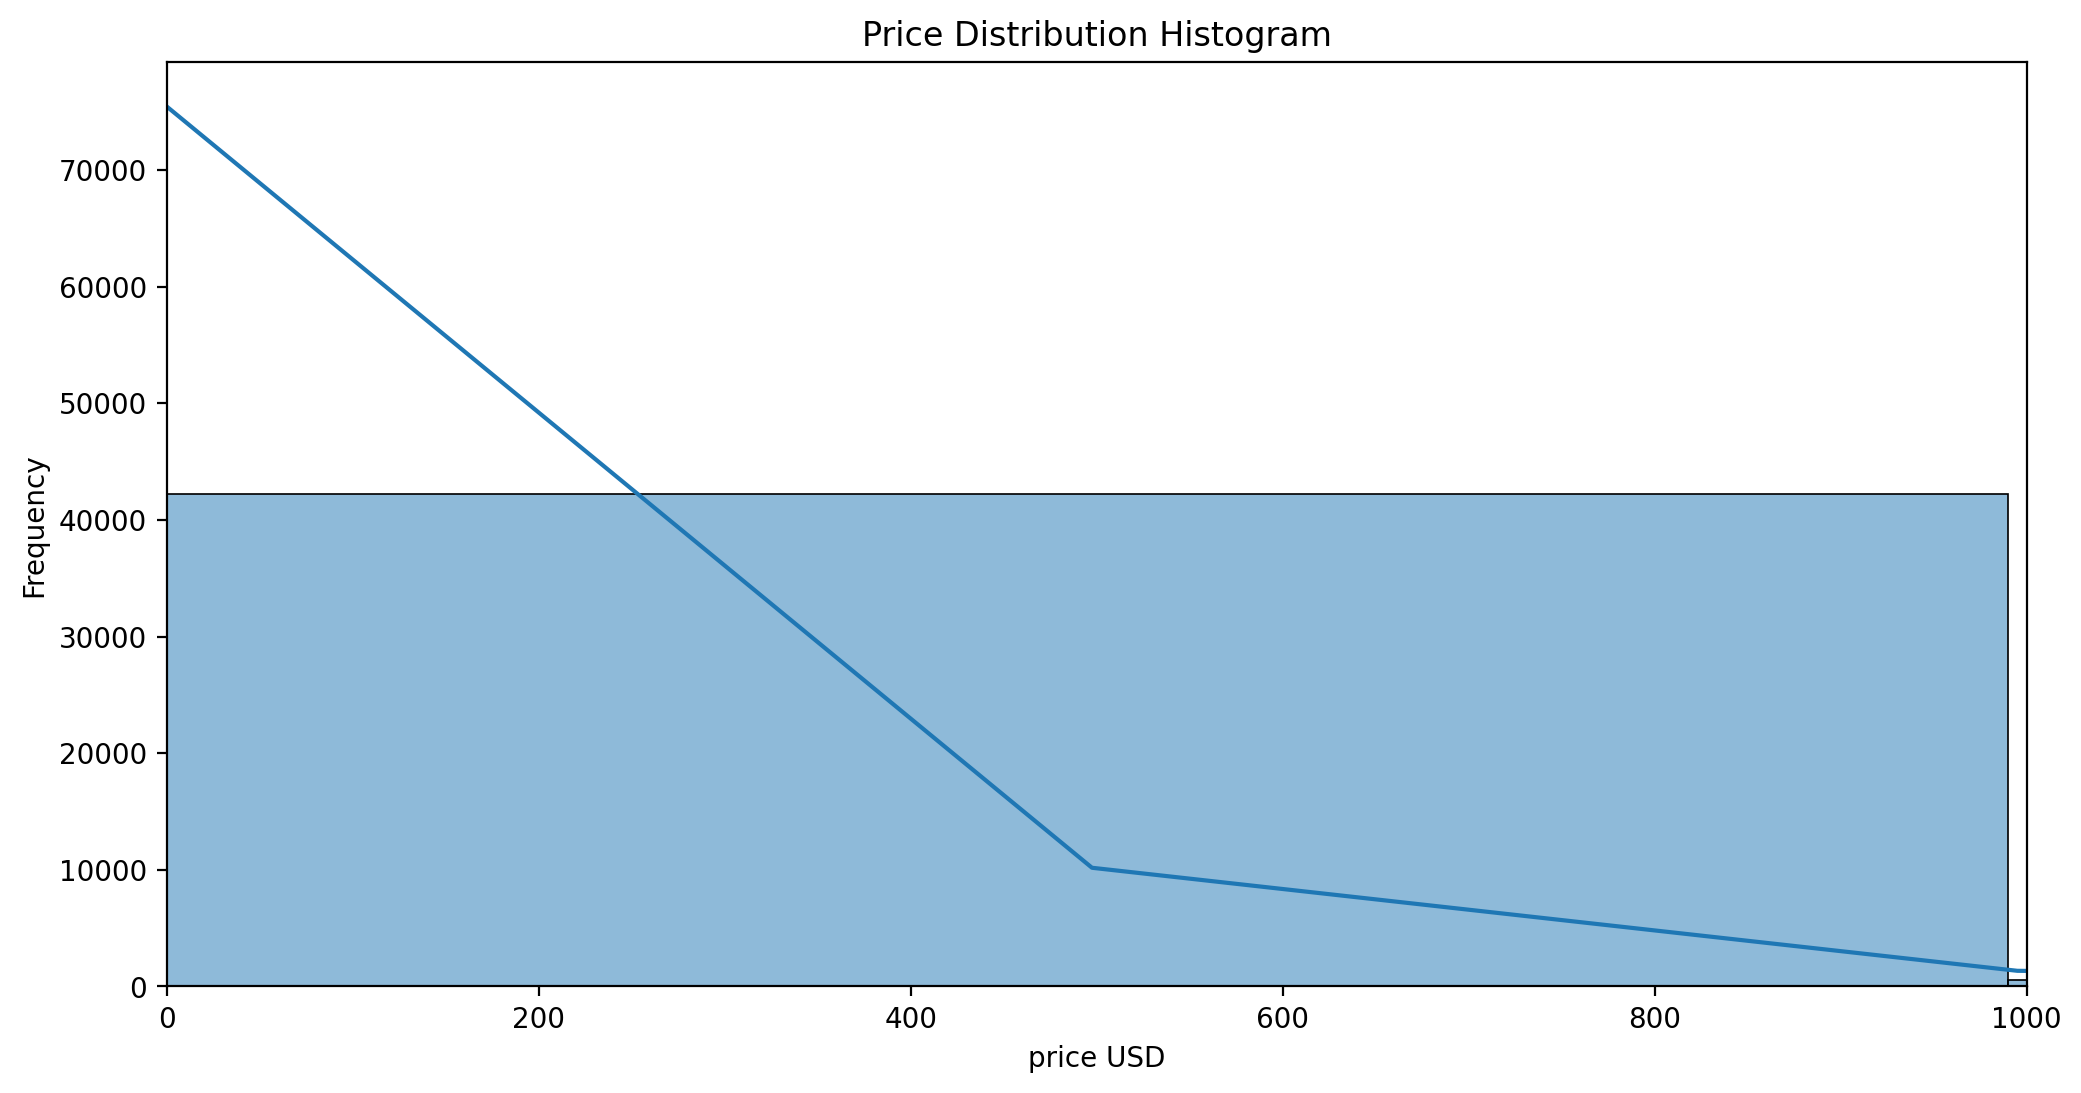

In [58]:
#Price distribution analysis
plt.figure(figsize=(12,6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('Price Distribution Histogram')
plt.xlim(0, 1000)  
plt.xlabel('price USD')
plt.ylabel('Frequency')
plt.show()

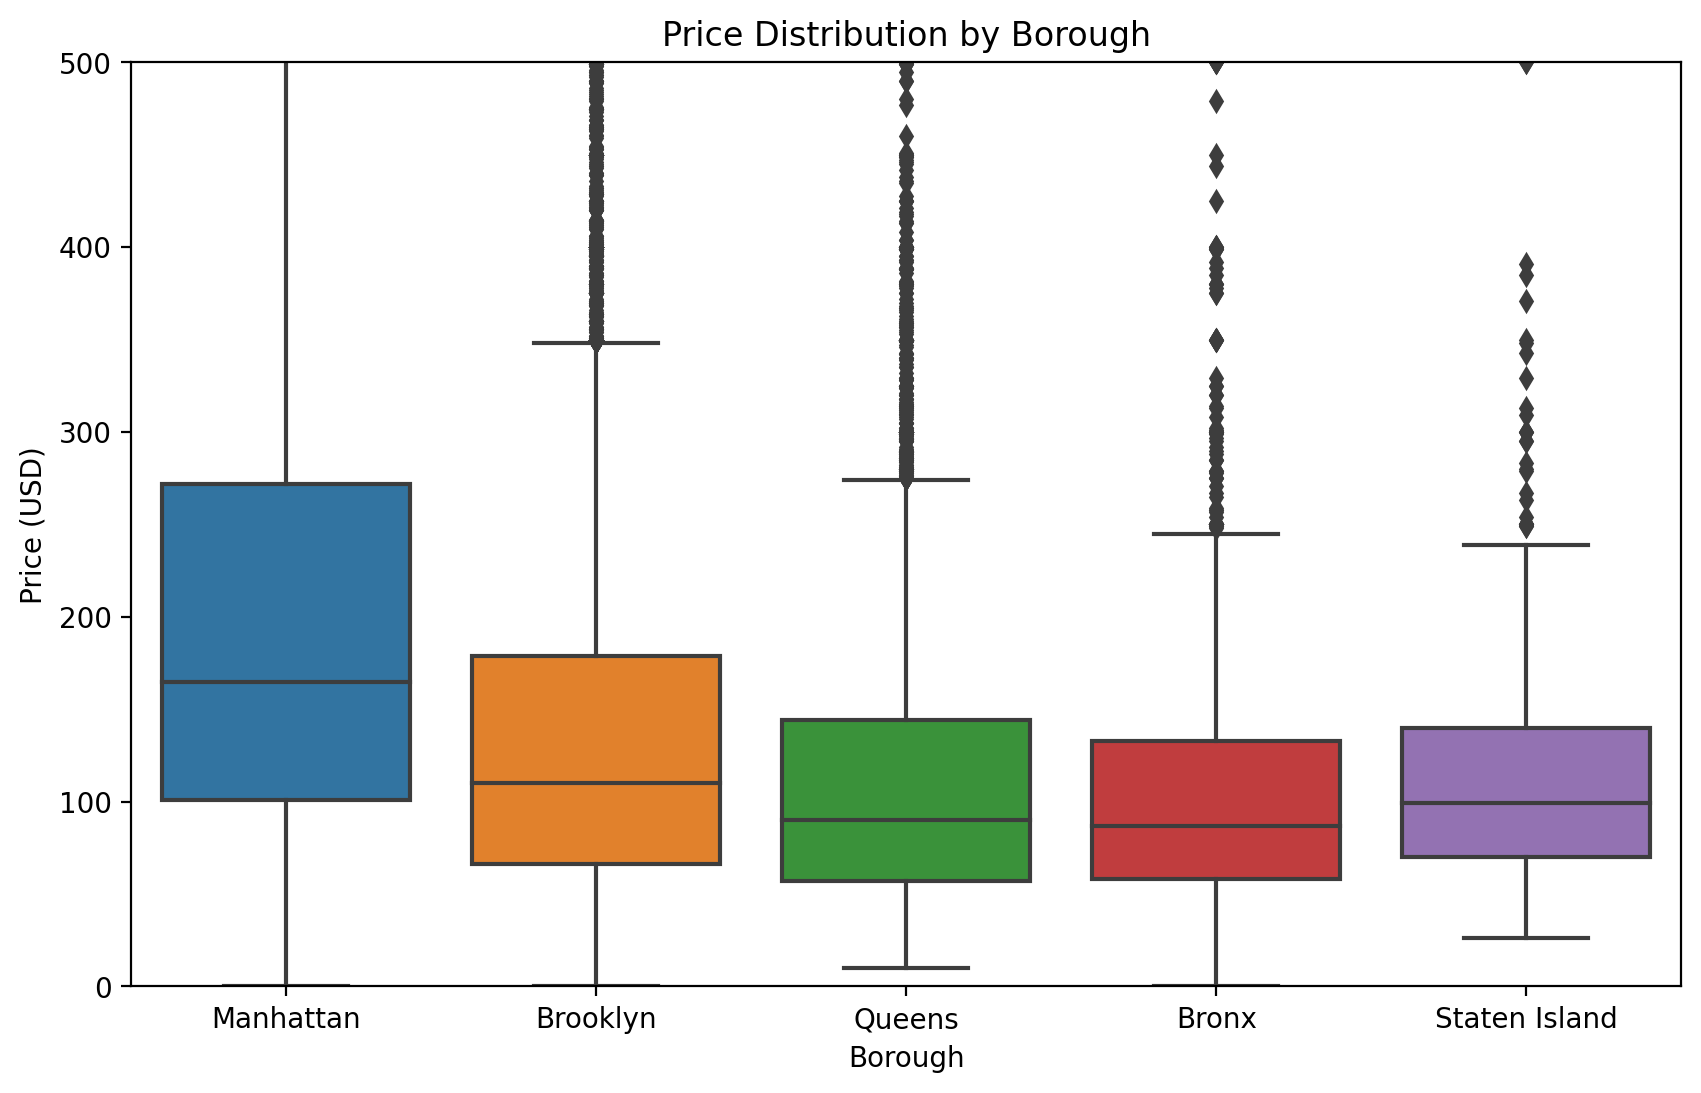

In [59]:
#Borough price comparison
plt.figure(figsize=(10,6))
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title('Price Distribution by Borough')
plt.ylim(0, 500)
plt.xlabel('Borough')
plt.ylabel('Price (USD)')
plt.show()

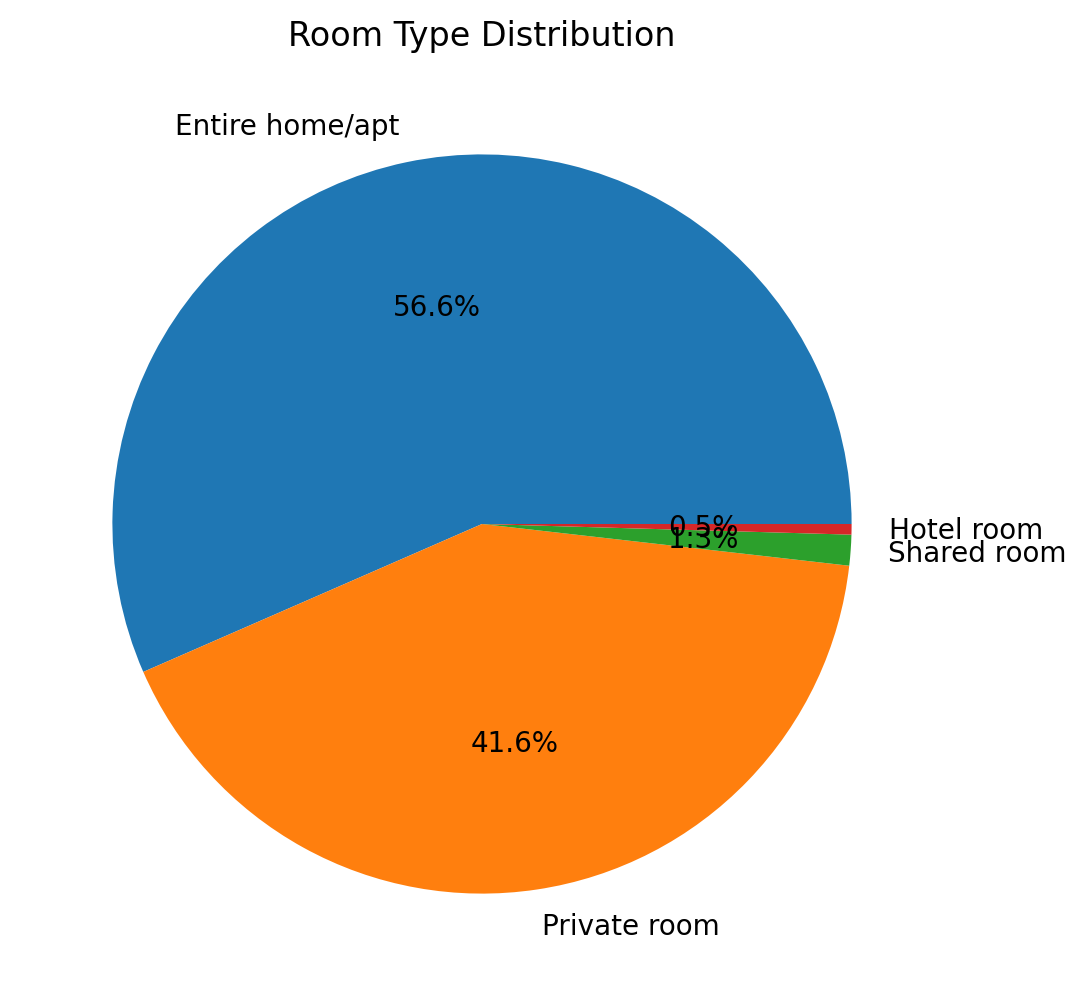

In [60]:
#Room type distribution
plt.figure(figsize=(10,6))
df['room_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Room Type Distribution')
plt.ylabel('')
plt.show()

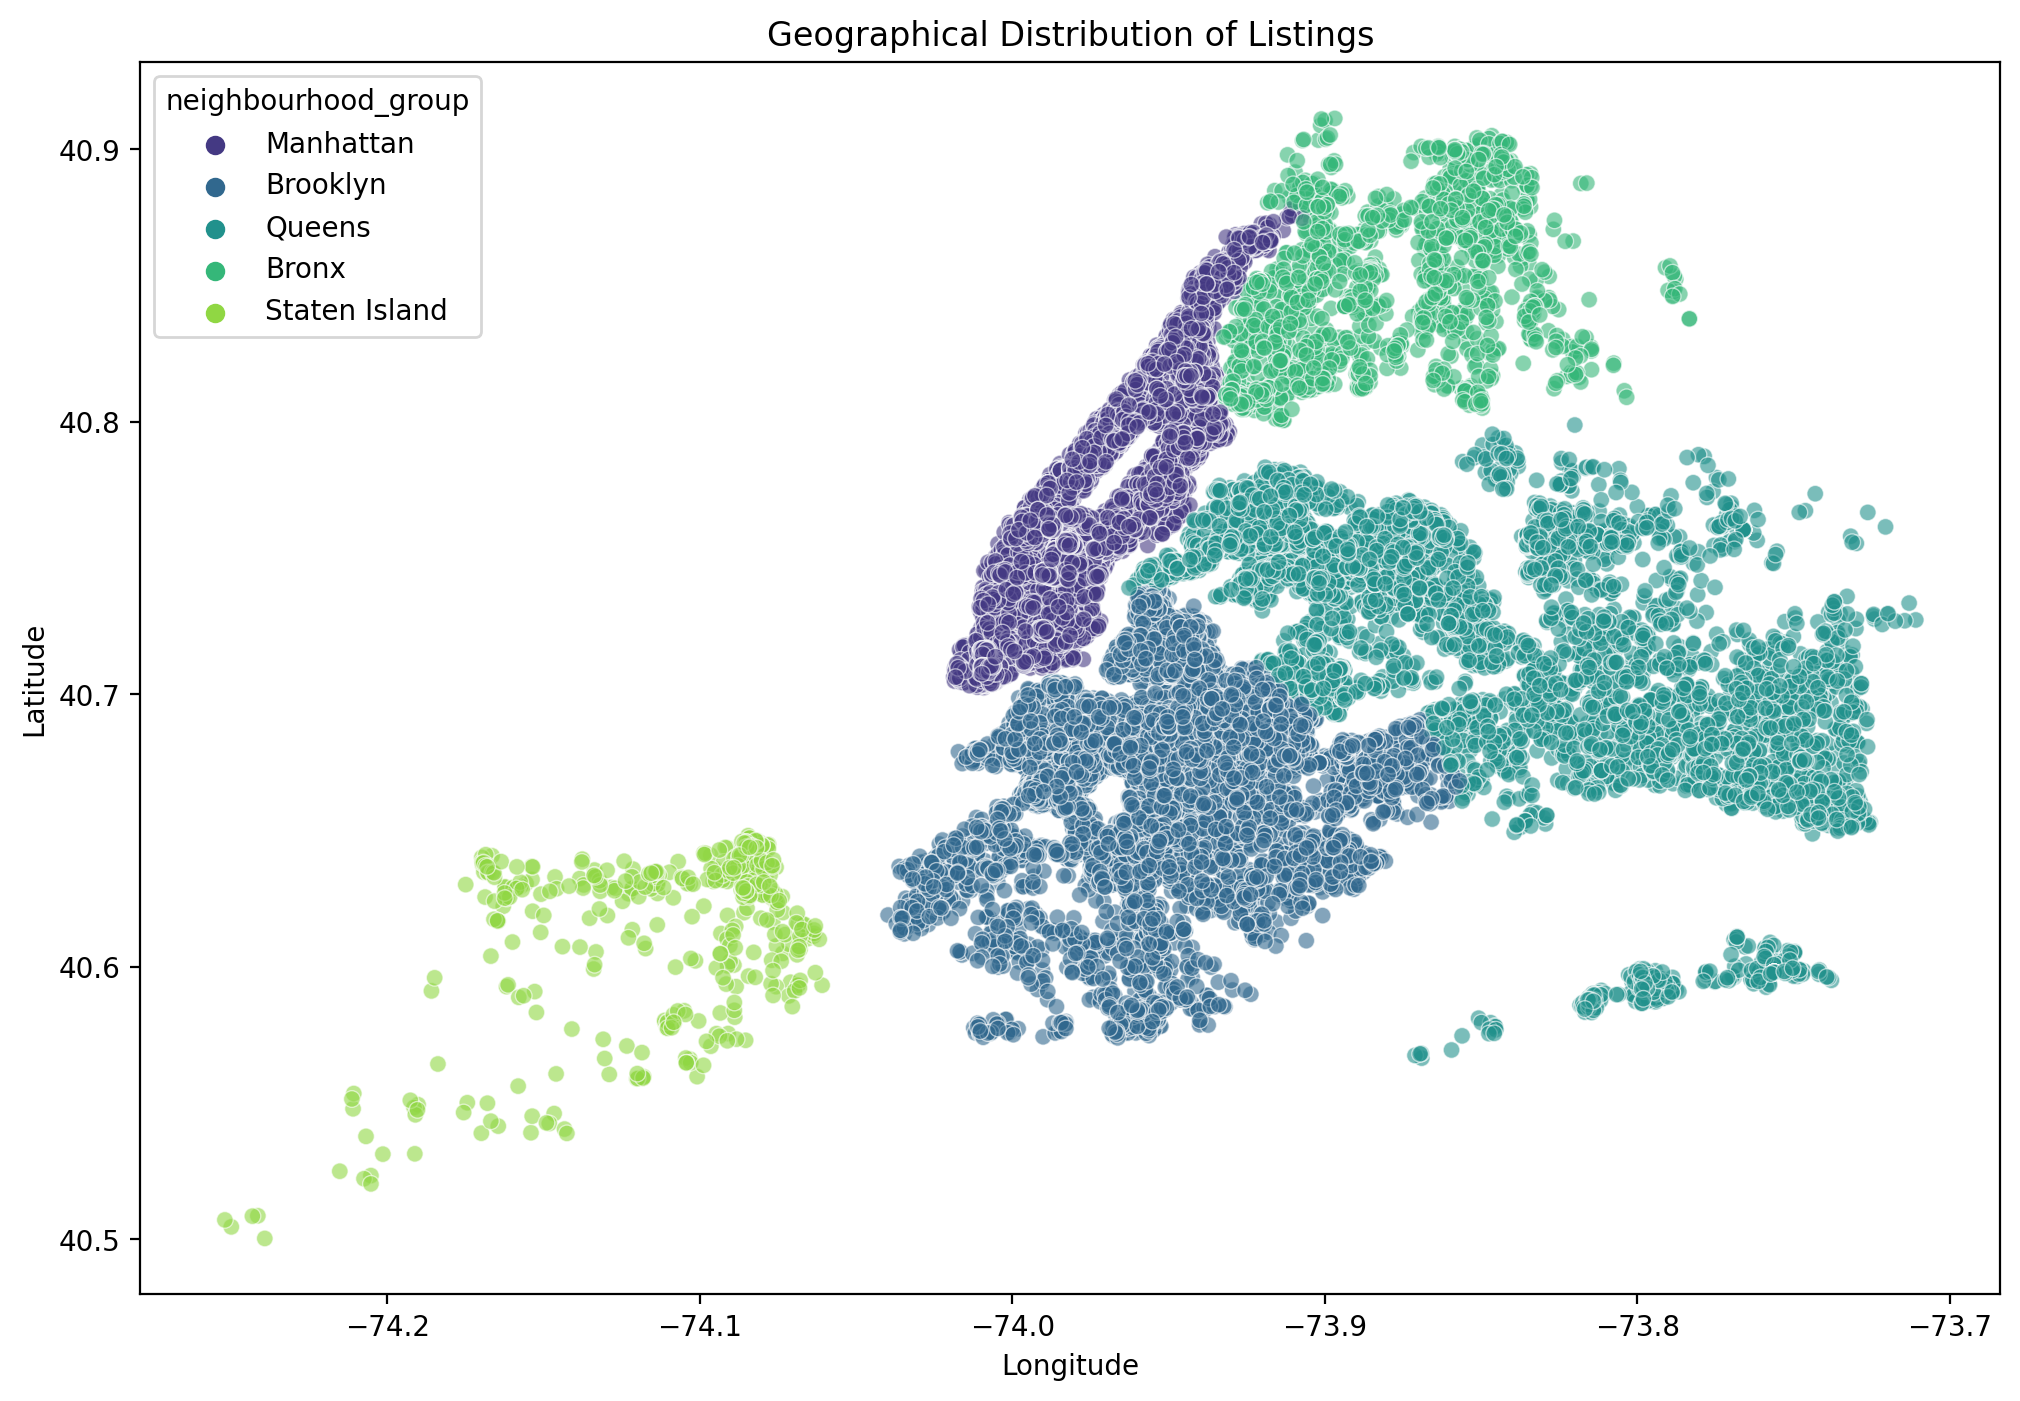

In [61]:
#Geographical distribution
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',
data=df, alpha=0.6, palette='viridis')
plt.title('Geographical Distribution of Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [62]:
#Feature selection and preprocessing
features = ['neighbourhood_group', 'room_type', 'latitude', 'longitude',
'minimum_nights', 'number_of_reviews', 'reviews_per_month',
'calculated_host_listings_count', 'availability_365']

target = 'price'

In [63]:
#outliers
df = df[(df['price'] > 20) & (df['price'] < 1000)]

In [64]:
#Split dataset
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
#Build preprocessing pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))  
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#Create machine learning pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('regressor', RandomForestRegressor()) 
])

#Grid search for parameter optimization
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}


In [66]:
#Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Model R² score: {r2_score(y_test, y_pred):.3f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

Best parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Model R² score: 0.466
Root Mean Squared Error (RMSE): 98.42


In [67]:
#Extract feature importance
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
cat_columns = encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_columns)

importances = best_model.named_steps['regressor'].feature_importances_

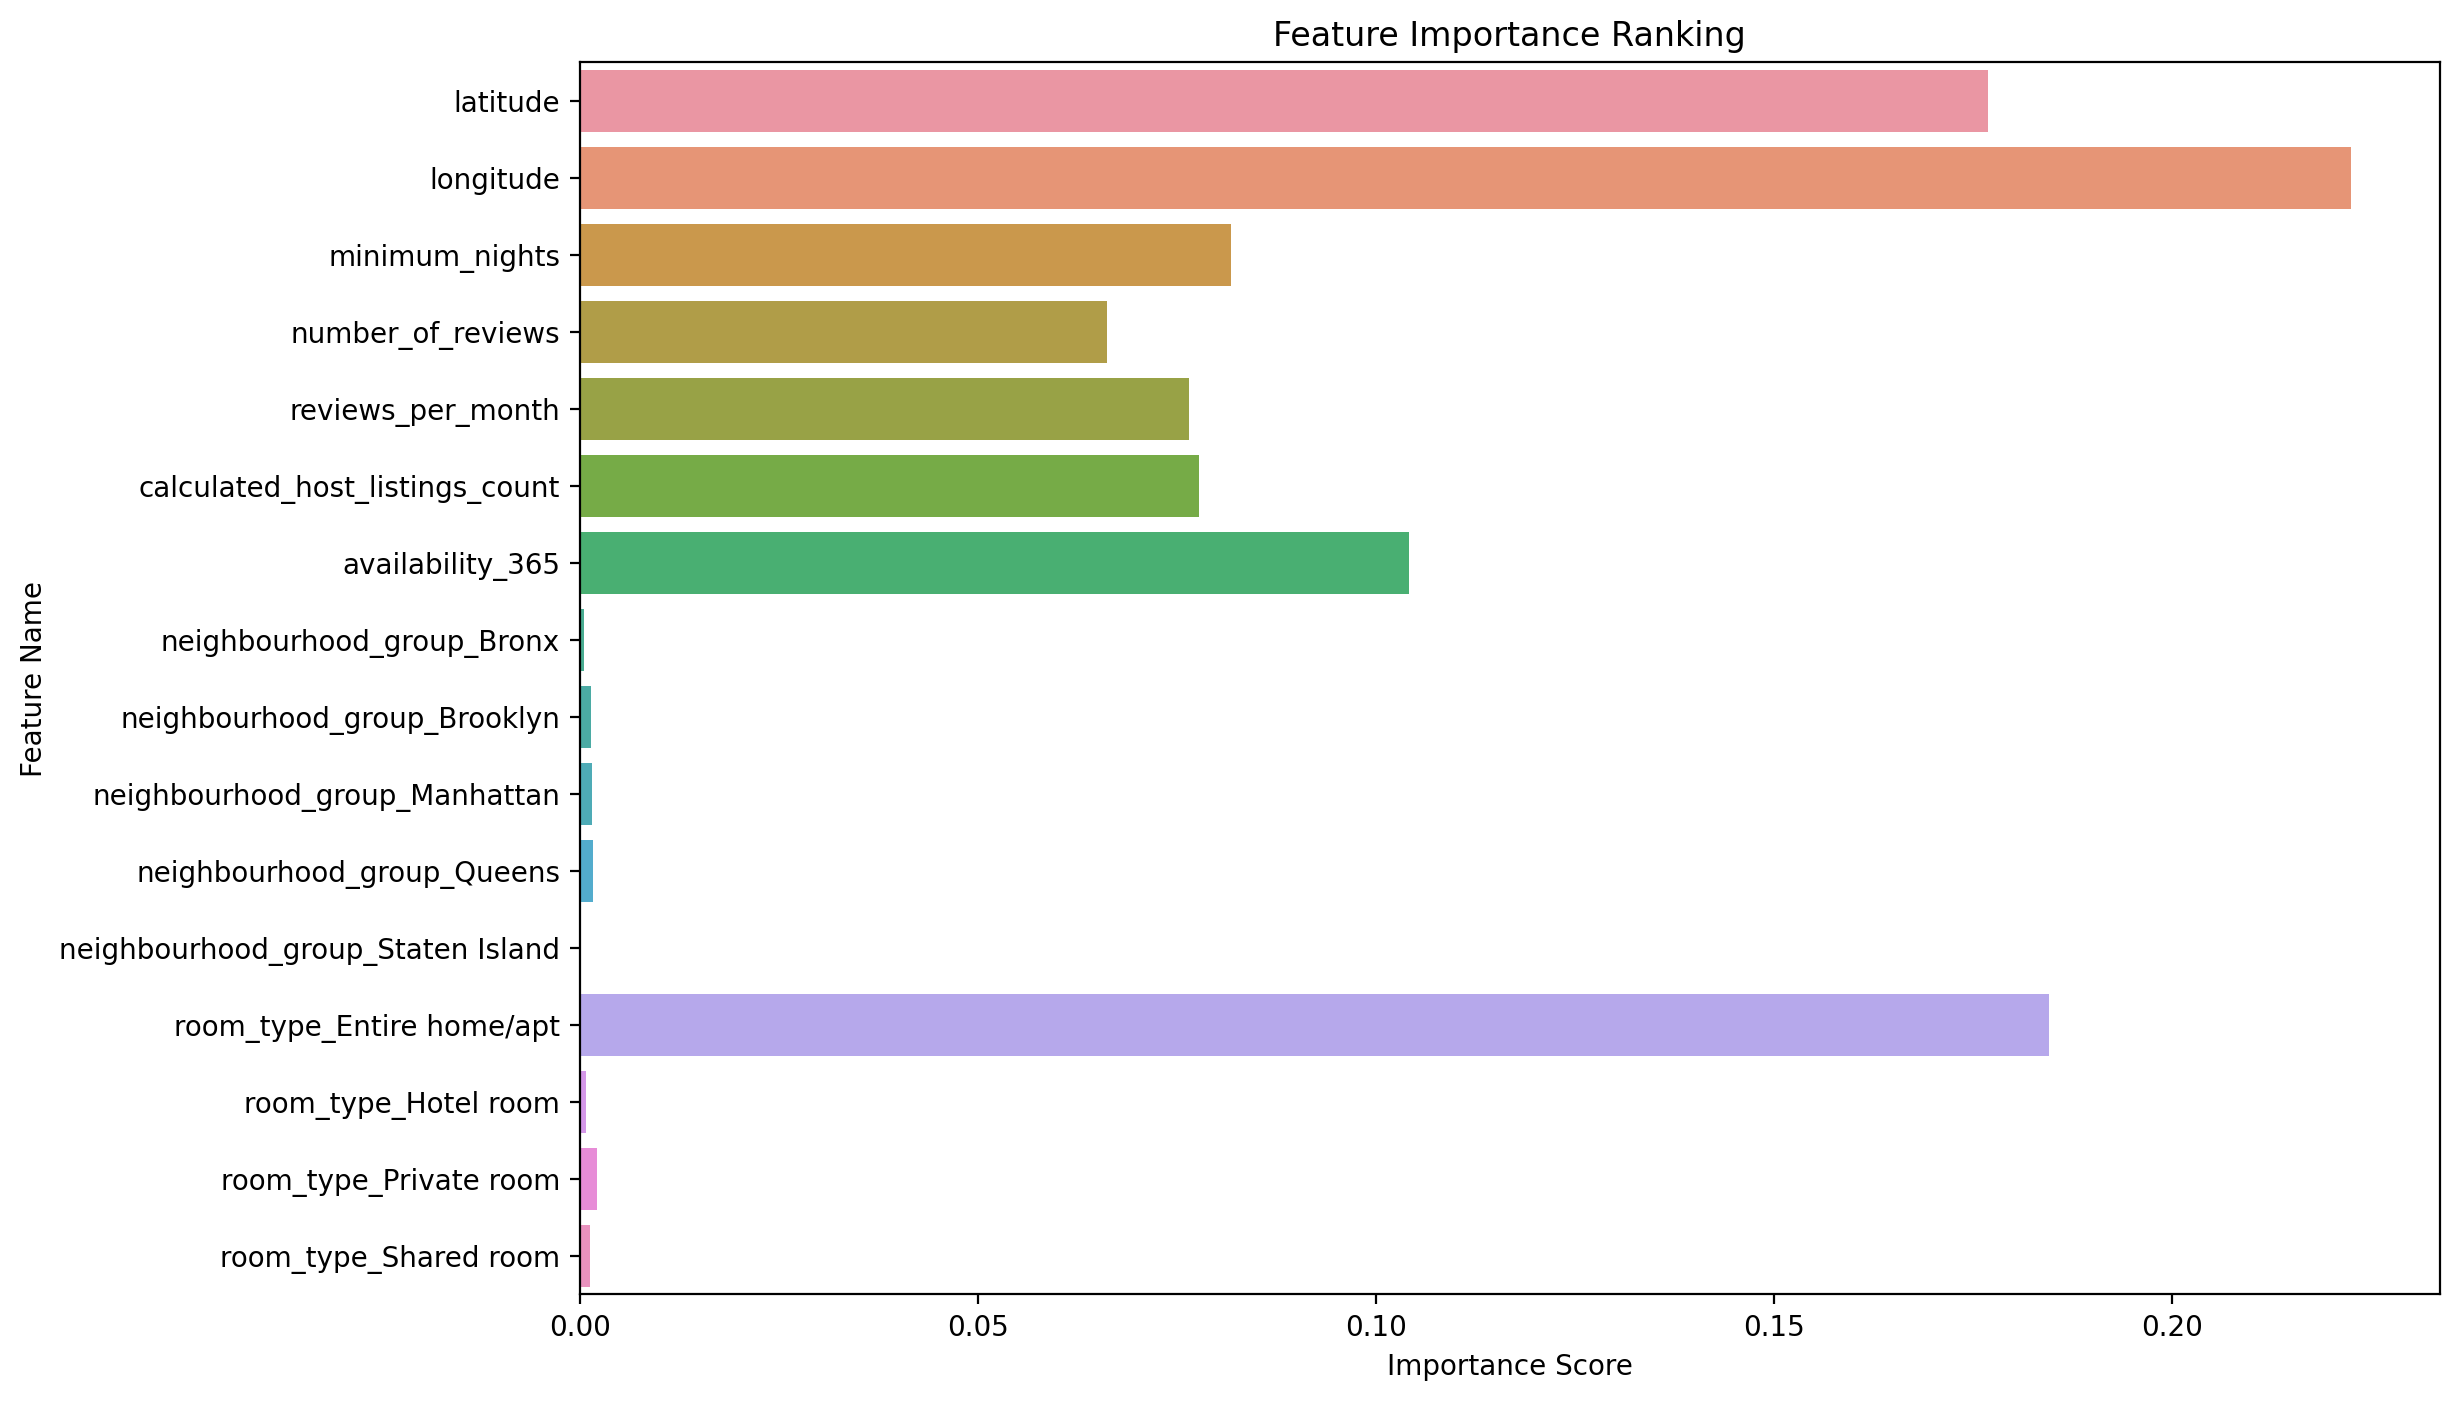

In [68]:
#Visualize feature importance
plt.figure(figsize=(12,8))
sns.barplot(x=importances, y=all_features)
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

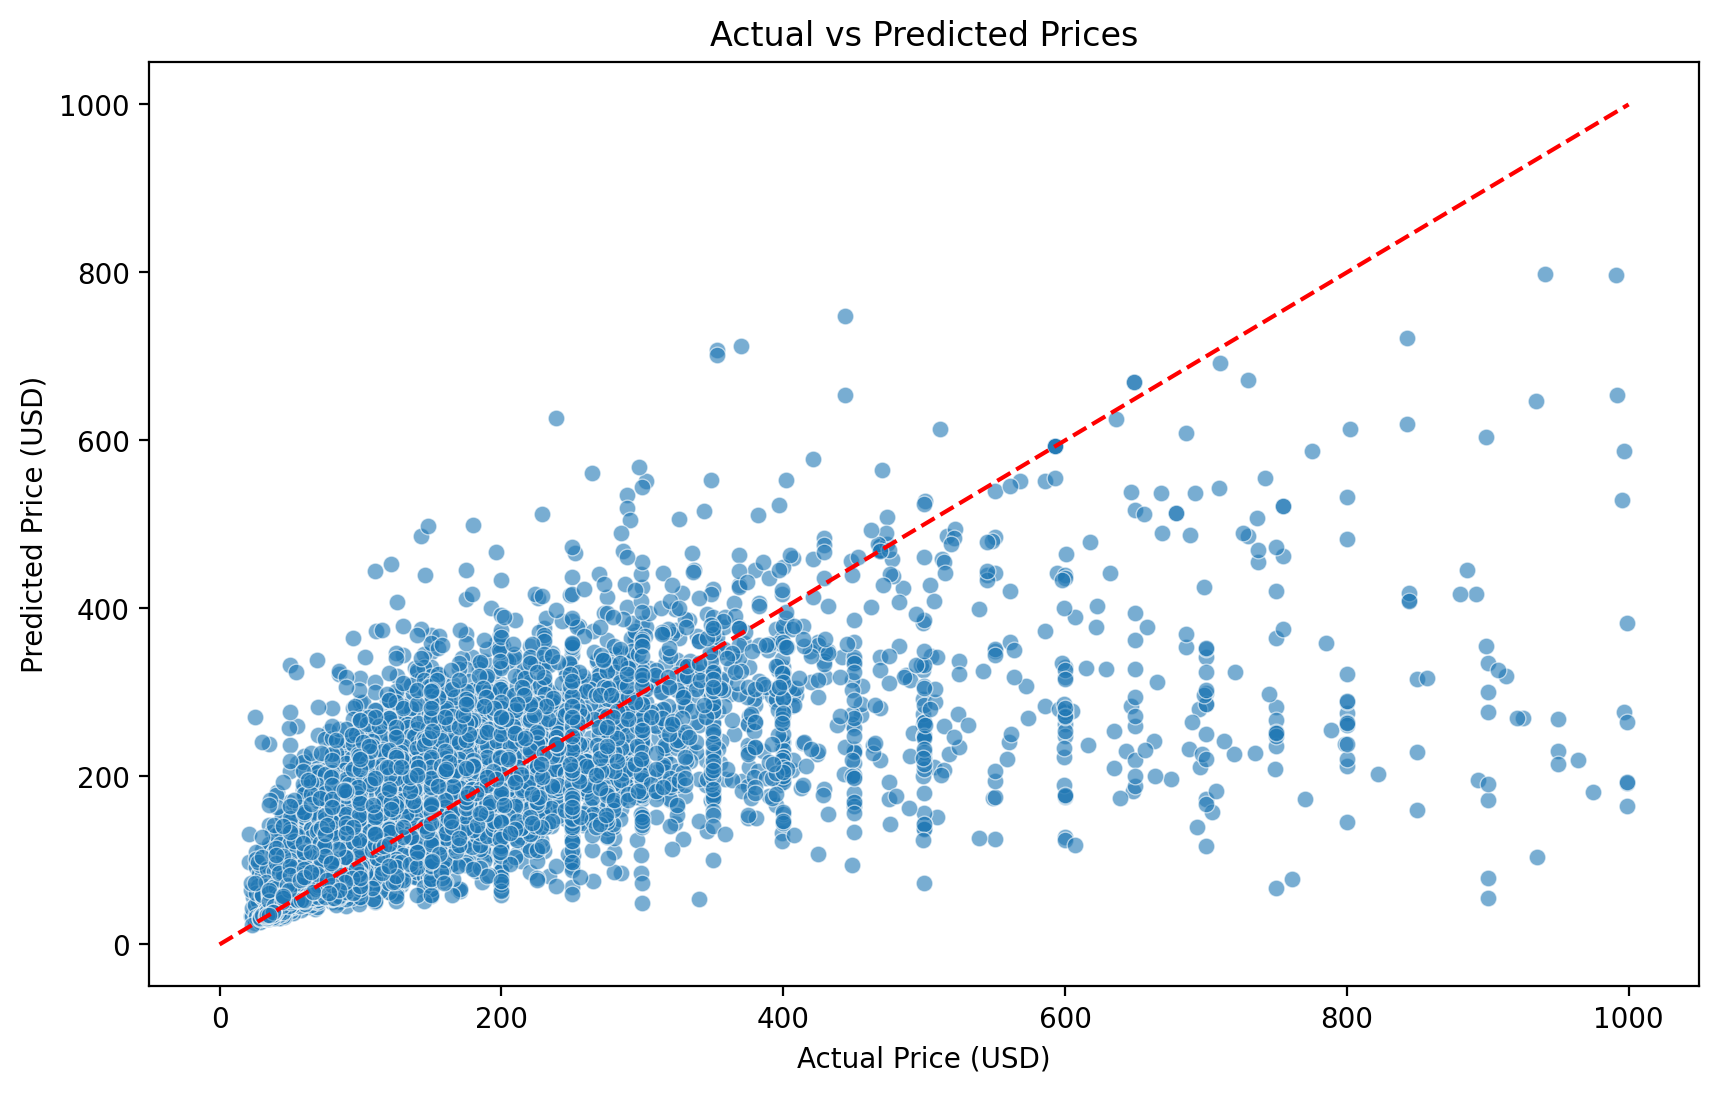

In [69]:
#Actual vs Predicted prices
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('Actual vs Predicted Prices')
plt.show()

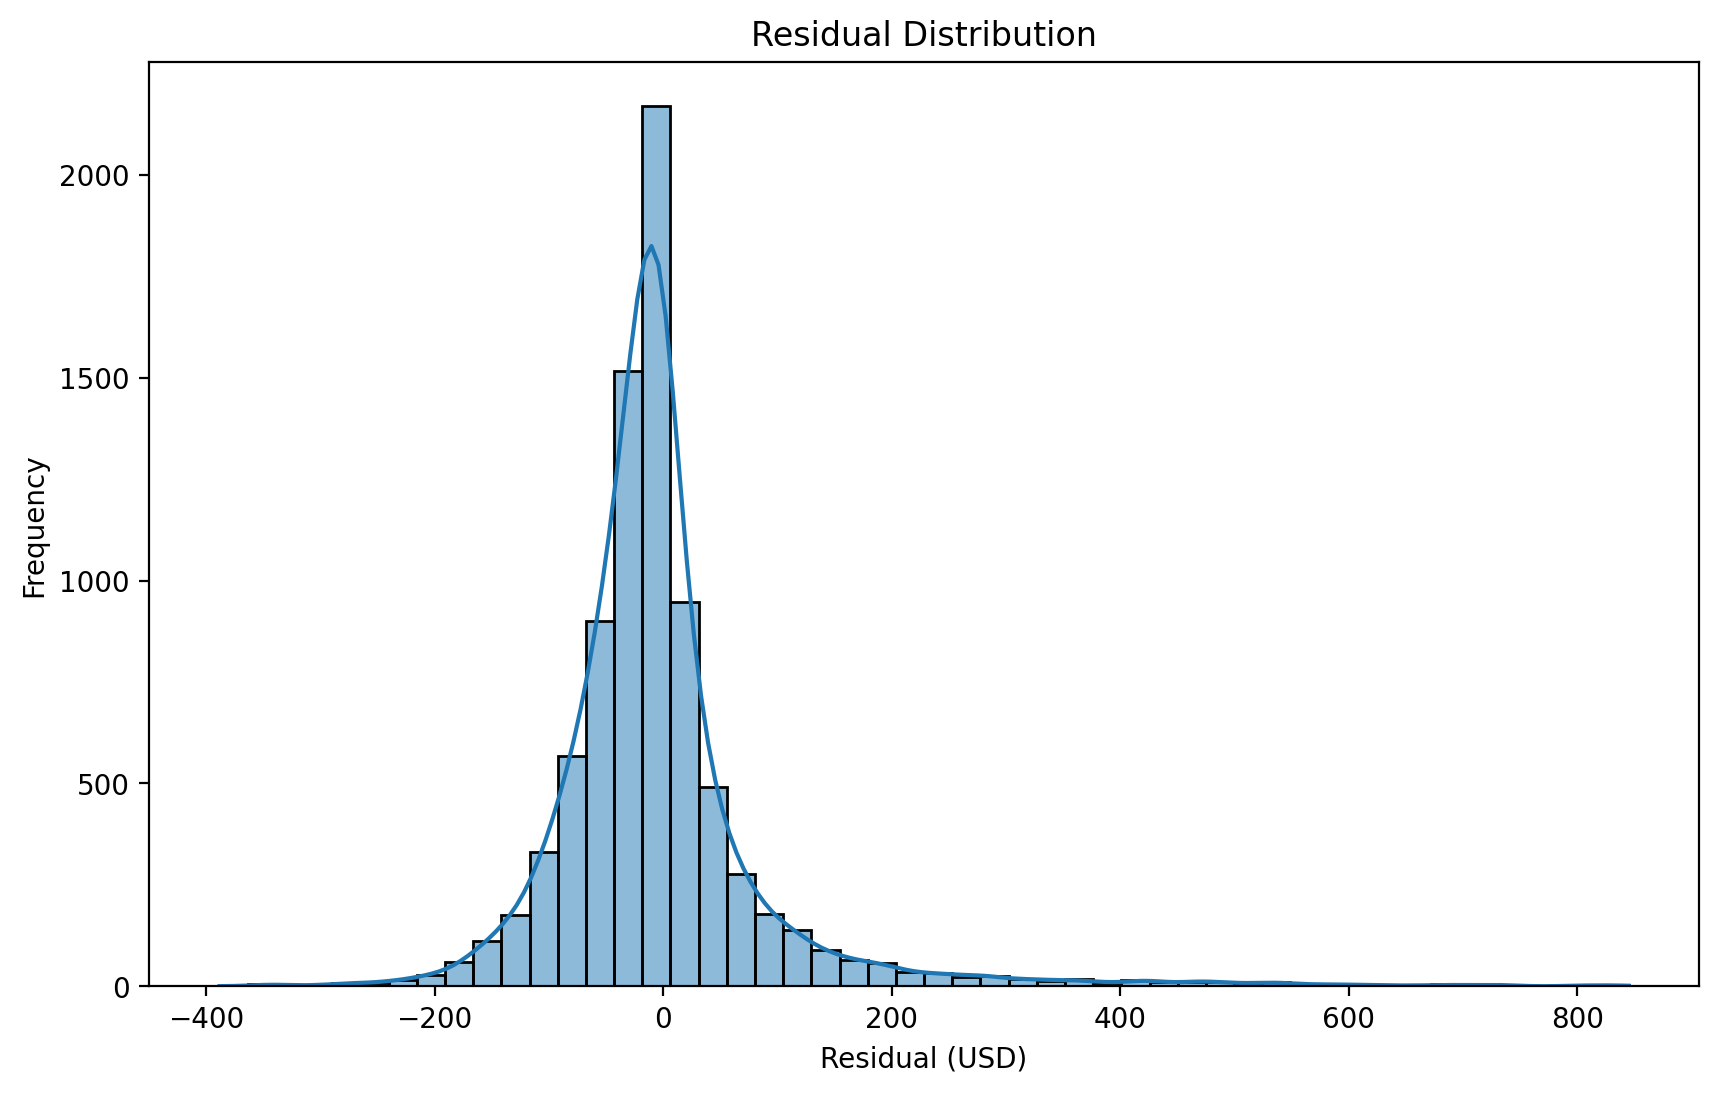

In [70]:
#Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residual (USD)')
plt.ylabel('Frequency')
plt.show()